# O método Pseudo-Espectral - Ondas em 2D

Este notebook aborda os seguintes pontos:
* Apresenta um algoritmo de Pseudo-espectral de Fourier para resolver a equação de onda em 2D;
* Resolve essa equação por um esquema de diferenças finitas para comparar;
* Analiza o comportamento dispersivo em cada um dos casos. 


## Equações básicas

Podemos resolver a equação de onda:

\begin{equation*}
\frac{\partial^2 u}{\partial t^2} = c^2 \bigg(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \bigg) + s
\end{equation*}

usando diferenças finitas, em  conjugação com um método espectral. No caso da equação de onda, as derivadas parciais espaciais relativamente a $x$ e a $y$ podem ser avaliadas através de um método de Fourier, i.é.,: 

\begin{equation*}
\frac{\partial^2 u}{\partial t^2} = \mathscr{F}^{-1}[-k_{x}^{2}\mathscr{F}[u]] + \mathscr{F}^{-1}[-k_{y}^{2}\mathscr{F}[u]],
\end{equation*}

onde $\mathscr{F}$ representa o operador transformada de Fourier.

Vamos usar (como já fizémos noutros exemplos) um operador de diferenças centrais de 3 pontos para aproximar as derivadas no tempo. Desse modo, o campo é extrapolado como

\begin{equation*}
\frac{u_{j,k}^{n+1} - 2u_{j,k}^{n} + u_{j,k}^{n-1}}{\Delta t^2}= c_{j,k}^{2} \bigg(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \bigg)_{j,k} + s_{j,k}^{n}
\end{equation*}

In [1]:
# Importar todas as bibliotecas necessárias.
# É preciso correr antes do código restante, para a simulação!
import numpy as np
import matplotlib
# mostrar plots no notebook
matplotlib.use("nbagg")
import matplotlib.pyplot as plt
from ricker import ricker   # esta função dá uma "pedra-no-charco", usada para função inicial!

### 1. Método da derivada de Fourier 

In [2]:
def fourier_derivative_2nd(f, dx):
    nx = np.size(f)  # comprimento do vector f
    
    # Inicializa o vector dos k até ao número de onda de Nyquist 
    kmax = np.pi / dx
    dk = kmax / (nx / 2)
    k = np.arange(float(nx))
    k[: int(nx/2)] = k[: int(nx/2)] * dk 
    k[int(nx/2) :] = k[: int(nx/2)] - kmax
    
    # derivada de Fourier
    ff = np.fft.fft(f)
    ff = (1j*k)**2 * ff
    df_num = np.real(np.fft.ifft(ff))
    return df_num

### 2. Definição do problema

In [3]:
# parâmetros
# ---------------------------------------------------------------
nt    = 600     # número de passos no tempo
nx    = 256     # número de pontos na grelha em x 
ny    = nx      # número de pontos na grelha em y
c     = 343.    # velocidada de fase
eps   = .2      # fracção do limite de estabilidade
isnau = 600     # frequência de plots
isx   = int(nx/2)   # posição da fonte
isy   = int(ny/2)
f0    = 200.    # Frequência de pico (a dividir por 5)
xmax  = 200
iplot = 20

# inicialização dos campos, au para FD, su para espectral
au = np.zeros((nx, ny), dtype=float)
aunew = np.zeros((nx, ny), dtype=float)
auold = np.zeros((nx, ny), dtype=float)
ad2ux = np.zeros((nx, ny), dtype=float)
ad2uy = np.zeros((nx, ny), dtype=float) 
 
su = np.zeros((nx, ny), dtype= float)
sunew = np.zeros((nx, ny), dtype=float)
suold = np.zeros((nx, ny), dtype=float)
sd2ux = np.zeros((nx, ny), dtype=float)
sd2uy = np.zeros((nx, ny), dtype=float); 

su_sec = -np.abs(su[1:int(nx/2), 1:int(ny/2)])  # devido à simetria, só plot o 1º quadrante
au_sec = -np.abs(au[int(nx/2):nx, 1:int(ny/2)].T)# ...e aqui só o 2º quadrante

dx = xmax/(nx-1)  # calcula passo espacial
x  = np.arange(0, nx)*dx # inicializa coordenadas espaciais: x...
y  = np.arange(0, nx)*dx #... e y
dt = eps*dx/c # calcula o passo temporal da condição de estabilidade

### 3. Inicialização da fonte 

In [4]:
# função para a variação temporal da fonte
# ---------------------------------------------------------------
t   = np.arange(1, nt+1)*dt  # inicializa vector dos tempos
T0  = 1./f0
tmp = ricker(dt, T0)
tmp = np.diff(tmp)
src = np.zeros(nt)
src[0:np.size(tmp)] = tmp
lam = c*T0

# função para a variação espacial da fonte
# ---------------------------------------------------------------
sg = np.zeros((nx, ny), dtype= float)
sigma = 1.5*dx
x0 = x[isx-1] 
y0 = y[isy-1] 
for i in range(nx):
    for j in range(ny):
        sg[i,j] = np.exp(-1/sigma**2 * ((x[i]-x0)**2 +(y[j]-y0)**2))
        
sg = sg/np.amax(sg)

### 4. Extrapolação no tempo
A solução final para o  nosso problema da onda 2D com o esquema de discretização no tempo em diferenças finitas pode ser escrito como

\begin{equation*}
u_{j,k}^{n+1} = dt^2c_{j,k}^{2} (\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} )_{j,k} + \Delta t^2s_{j,k}^{n} + 2u_{j,k}^{n} - u_{j,k}^{n-1}
\end{equation*}

De modo a comparar a solução numérica acima, implementamos um operador de diferenças finitas de 5 pontos para calcular as derivadas espaciais

\begin{equation*}
\frac{\partial^2}{\partial t^2} u(x,t) = \frac{-u(x,t+2\Delta t) + 16u(x,t+\Delta t) - 30u(x,t) + 16u(x,t-\Delta t) - u(x,t-2\Delta t)}{12\Delta t^2} 
\end{equation*}

e a derivada temporal é feita, tal como no método pseudo-espectral, com um esquema de diferenças finitas de 3 pontos.

#### Dispersão numérica e anisotropia

Uma das principais características do método de Fourier é a sua baixa dispersão numérica, quando comparada com o método de diferenças finitas. As duas representações (para o mesmo instante) de cada solução mostradas abaixo permitem verificar que:

1) Há uma forte dispersão anisotrópica na solução por diferenças finitas. A direcção em que esta é mais precisa é $\theta = \pi/4$ ;

2) A solução de Fourier não mostra quaisquer sinais visíveis de dispersão, mas mais importante, não exibe qualquer dependência na direcção. Por outras palavras, o seu erro é isotrópico.

<IPython.core.display.Javascript object>


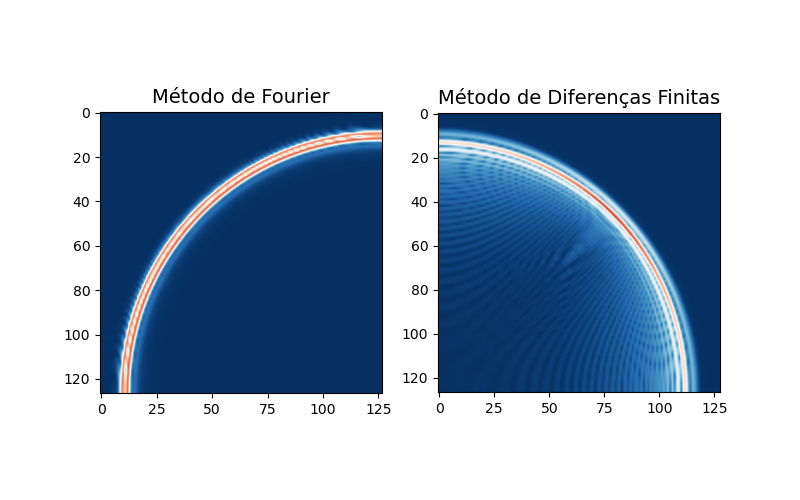

In [5]:
# Inicializa a animação
# ---------------------------------------------------------------
fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
line1 = ax1.imshow(su_sec, interpolation="bicubic", cmap=plt.cm.RdBu)
line2 = ax2.imshow(au_sec, interpolation="bicubic", cmap=plt.cm.RdBu)
ax1.set_title('Método de Fourier', size=14)
ax2.set_title('Método de Diferenças Finitas', size=14)

plt.ion()   # pôr em modo interactivo
plt.show()


<IPython.core.display.Javascript object>


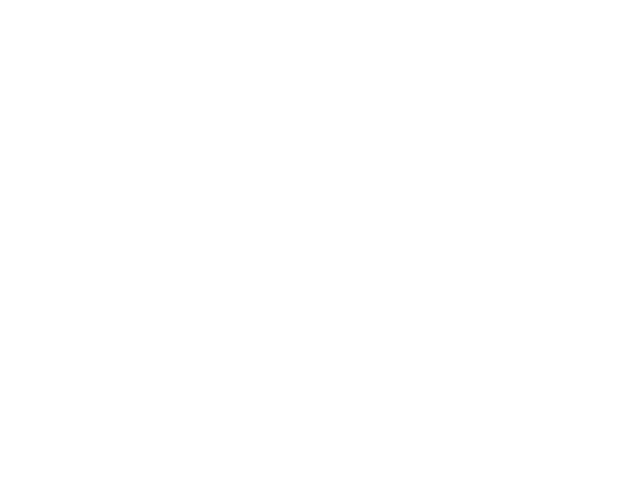

In [7]:
# Evolução no tempo
# ---------------------------------------------------------------
for it in range(nt):
   
    # ----------------------------------------
    # Método de Fourier Pseudo-espectral
    # ----------------------------------------
    # 2nd derivada no espaço 
    for j in np.arange(ny):           
        sd2ux[:,j] = fourier_derivative_2nd(su[:,j].T, dx) 
    for i in np.arange(nx):           
        sd2uy[i,:] = fourier_derivative_2nd(su[i,:], dx)
        
    # extrapolação temporal
    sunew = 2*su - suold + c**2 * dt**2 * (sd2ux + sd2uy)    
    sunew = sunew + sg*src[it]*dt**2 # Add sources   
    suold, su = su, sunew # Time levels
    
    # ----------------------------------------
    # Método de  Diferenças Finitas de 5pt
    # ----------------------------------------
    for i in range(2, ny-2):
        ad2ux[i,:] = (-1./12*au[i+2,:] + 4./3*au[i+1,:] - 5./2*au[i,:] \
                      + 4./3*au[i-1,:] - 1./12*au[i-2,:])/dx**2 # Derivada espacial(x)
    for i in range(2, nx-2):
        ad2uy[:,i] = (-1./12*au[:,i+2] + 4./3*au[:,i+1] - 5./2*au[:,i] \
                      + 4./3*au[:,i-1] - 1./12*au[:,i-2])/dx**2 # Derivada espacial(y) 
        
    aunew = 2*au - auold + dt**2 * c**2 * (ad2ux + ad2uy) # esquema temporal    
    aunew = aunew + sg*src[it]*dt**2 # Adiciona a fonte    
    auold, au = au, aunew # Actualiza níveis temporarais
    
    # Selecciona secções para plot
    su_sec = -np.abs(su[1:int(nx/2), 1:int(ny/2)])
    au_sec = -np.abs(au[int(nx/2):nx, 1:int(ny/2)].T)
    
    # --------------------------------------  
    # Animação  
    # --------------------------------------
    if not it % iplot:                    
        # Exibe solução
        # -------------------------------------- 
        line1 = ax1.imshow(su_sec, interpolation="bicubic", cmap=plt.cm.RdBu) 
        line2 = ax2.imshow(au_sec, interpolation="bicubic", cmap=plt.cm.RdBu)
        plt.gcf().canvas.draw()
     